このノートブックは下記の参考文献を元にKaggleの「Santa's Workshop Tour 2019」コンペで

最適化問題（線形計画法など）を学んだ。


# 【参考文献】

・[Santa's Assistant - Learning LP from others](https://www.kaggle.com/kathakaliseth/santa-s-assistant-learning-lp-from-others)

・[ Intro to Santa's 2019: Viz, Costs(22μs) and Search](https://www.kaggle.com/jesperdramsch/intro-to-santa-s-2019-viz-costs-22-s-and-search)

・[Santa's 2019: Stochastic Product Search](https://www.kaggle.com/xhlulu/santa-s-2019-stochastic-product-search)

・[python の最適化ツール ortools について](http://ietoa.blogspot.com/2018/07/python-ortools.html)

In [1]:
from itertools import product
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
%matplotlib inline

In [2]:
def get_penalty(n, choice):
    penalty = None
    if choice == 0:
        penalty = 0
    elif choice == 1:
        penalty = 50
    elif choice == 2:
        penalty = 50 + 9 * n
    elif choice == 3:
        penalty = 100 + 9 * n
    elif choice == 4:
        penalty = 200 + 9 * n
    elif choice == 5:
        penalty = 200 + 18 * n
    elif choice == 6:
        penalty = 300 + 18 * n
    elif choice == 7:
        penalty = 300 + 36 * n
    elif choice == 8:
        penalty = 400 + 36 * n
    elif choice == 9:
        penalty = 500 + 36 * n + 199 * n
    else:
        penalty = 500 + 36 * n + 398 * n
    return penalty

In [3]:
def GetPreferenceCostMatrix(data):
    cost_matrix = np.zeros((N_FAMILIES, N_DAYS), dtype=np.int64)
    for i in range(N_FAMILIES):
        desired = data.values[i, :-1]
        cost_matrix[i, :] = get_penalty(FAMILY_SIZE[i], 10)  #全部にotherwiseのpenalty
        for j, day in enumerate(desired):
            cost_matrix[i, day-1] = get_penalty(FAMILY_SIZE[i], j)
    return cost_matrix


def GetAccountingCostMatrix():
    acc_costs = np.zeros((176, 326), dtype=np.float64)
    for n in range(acc_costs.shape[1]):
        for diff in range(acc_costs.shape[0]):
            acc_costs[diff, n] = max(0, ((n - 125) / 400) * n**(0.5 + (diff / 50.0)))
    return acc_costs

In [4]:
penalty_values = []
for j in (2,3,4,5,6,7,8):
    for i in range(10):
        penalty_values = pd.DataFrame([i,j,get_penalty(j, i)] for j in (2,3,4,5,6,7,8)  for i in range(10))
penalty_values.columns = ['Choice', 'Family_Size', 'Penalty']        
print(penalty_values)

    Choice  Family_Size  Penalty
0        0            2        0
1        1            2       50
2        2            2       68
3        3            2      118
4        4            2      218
5        5            2      236
6        6            2      336
7        7            2      372
8        8            2      472
9        9            2      970
10       0            3        0
11       1            3       50
12       2            3       77
13       3            3      127
14       4            3      227
15       5            3      254
16       6            3      354
17       7            3      408
18       8            3      508
19       9            3     1205
20       0            4        0
21       1            4       50
22       2            4       86
23       3            4      136
24       4            4      236
25       5            4      272
26       6            4      372
27       7            4      444
28       8            4      544
29       9

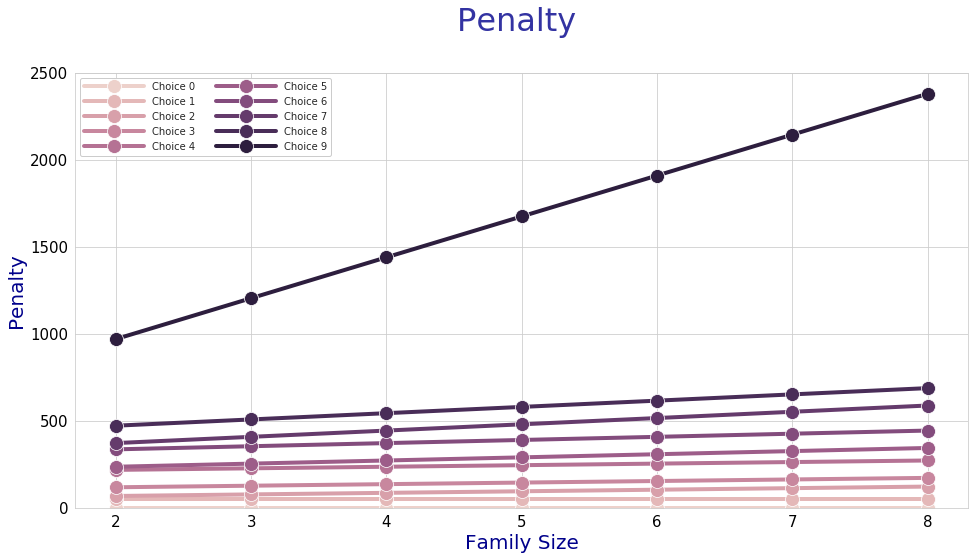

In [5]:
import matplotlib as mpl
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

sns.set_style("whitegrid")

ax = plt.figure(figsize=(16,8))

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))
 
ax = sns.lineplot(x="Family_Size", y="Penalty", data=penalty_values,linewidth=4,hue="Choice",color='darkblue',
                  marker='o',markersize=14)

plt.title("Penalty \n", loc="center",size=32,color='darkblue',alpha=0.8)
plt.xlabel('Family Size',color='darkblue',fontsize=20) 
plt.ylabel('Penalty',color='darkblue',fontsize=20)
plt.xticks(size=15,color='black',rotation='horizontal', wrap=True)
plt.yticks(size=15,color='black')
plt.ylim(0,2500)
plt.legend(loc='best', labels=['Choice 0','Choice 1','Choice 2','Choice 3','Choice 4','Choice 5','Choice 6','Choice 7',
                              'Choice 8','Choice 9'],
           handlelength=6,fontsize=10,ncol=2,framealpha=0.99)

Nd=126, diff=60 :  9.3018629258787
Nd=300, diff=20 :  74.19714363937197
It is better to keep whithin each lines.
The maximum cost is a ridiculous: 5578320312.5


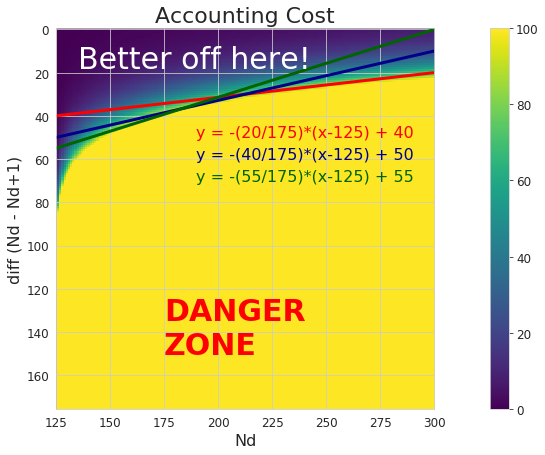

In [6]:
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

acc_costs = GetAccountingCostMatrix()

y2 = [-(20/175)*(x-125) + 40 for x in range(0, 301)]
y3 = [-(40/175)*(x-125) + 50 for x in range(0, 301)]
y4 = [-(55/175)*(x-125) + 55 for x in range(0, 301)]


plt.figure(figsize=(20,7))
plt.subplot(111)

plt.imshow(np.clip(acc_costs, 0, 100), cmap='viridis')
plt.plot(y2, color="red", linewidth=3)
plt.plot(y3, color="darkblue", linewidth=3)
plt.plot(y4, color="darkgreen", linewidth=3)
plt.title('Accounting Cost', fontsize=22)
plt.xlabel("Nd", fontsize=16)
plt.xlim([125, 300])
plt.xticks([125, 150, 175, 200, 225, 250, 275, 300])
plt.ylabel("diff (Nd - Nd+1)", fontsize=16)
plt.text(190, 50, "y = -(20/175)*(x-125) + 40", fontsize=16, color="red")
plt.text(190, 60, "y = -(40/175)*(x-125) + 50", fontsize=16, color="darkblue")
plt.text(190, 70, "y = -(55/175)*(x-125) + 55", fontsize=16, color="darkgreen")
plt.text(135, 18, "Better off here!", fontsize=30, color="white")
plt.text(175, 150, "DANGER\nZONE", fontsize=30, fontweight='heavy', color="red")
plt.colorbar()

print("Nd=126, diff=60 : ", acc_costs[60,126])
print("Nd=300, diff=20 : ", acc_costs[20,300])
print("It is better to keep whithin each lines.")
print("The maximum cost is a ridiculous:", acc_costs.max())

In [7]:
data = pd.read_csv('./family_data.csv', index_col='family_id')
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


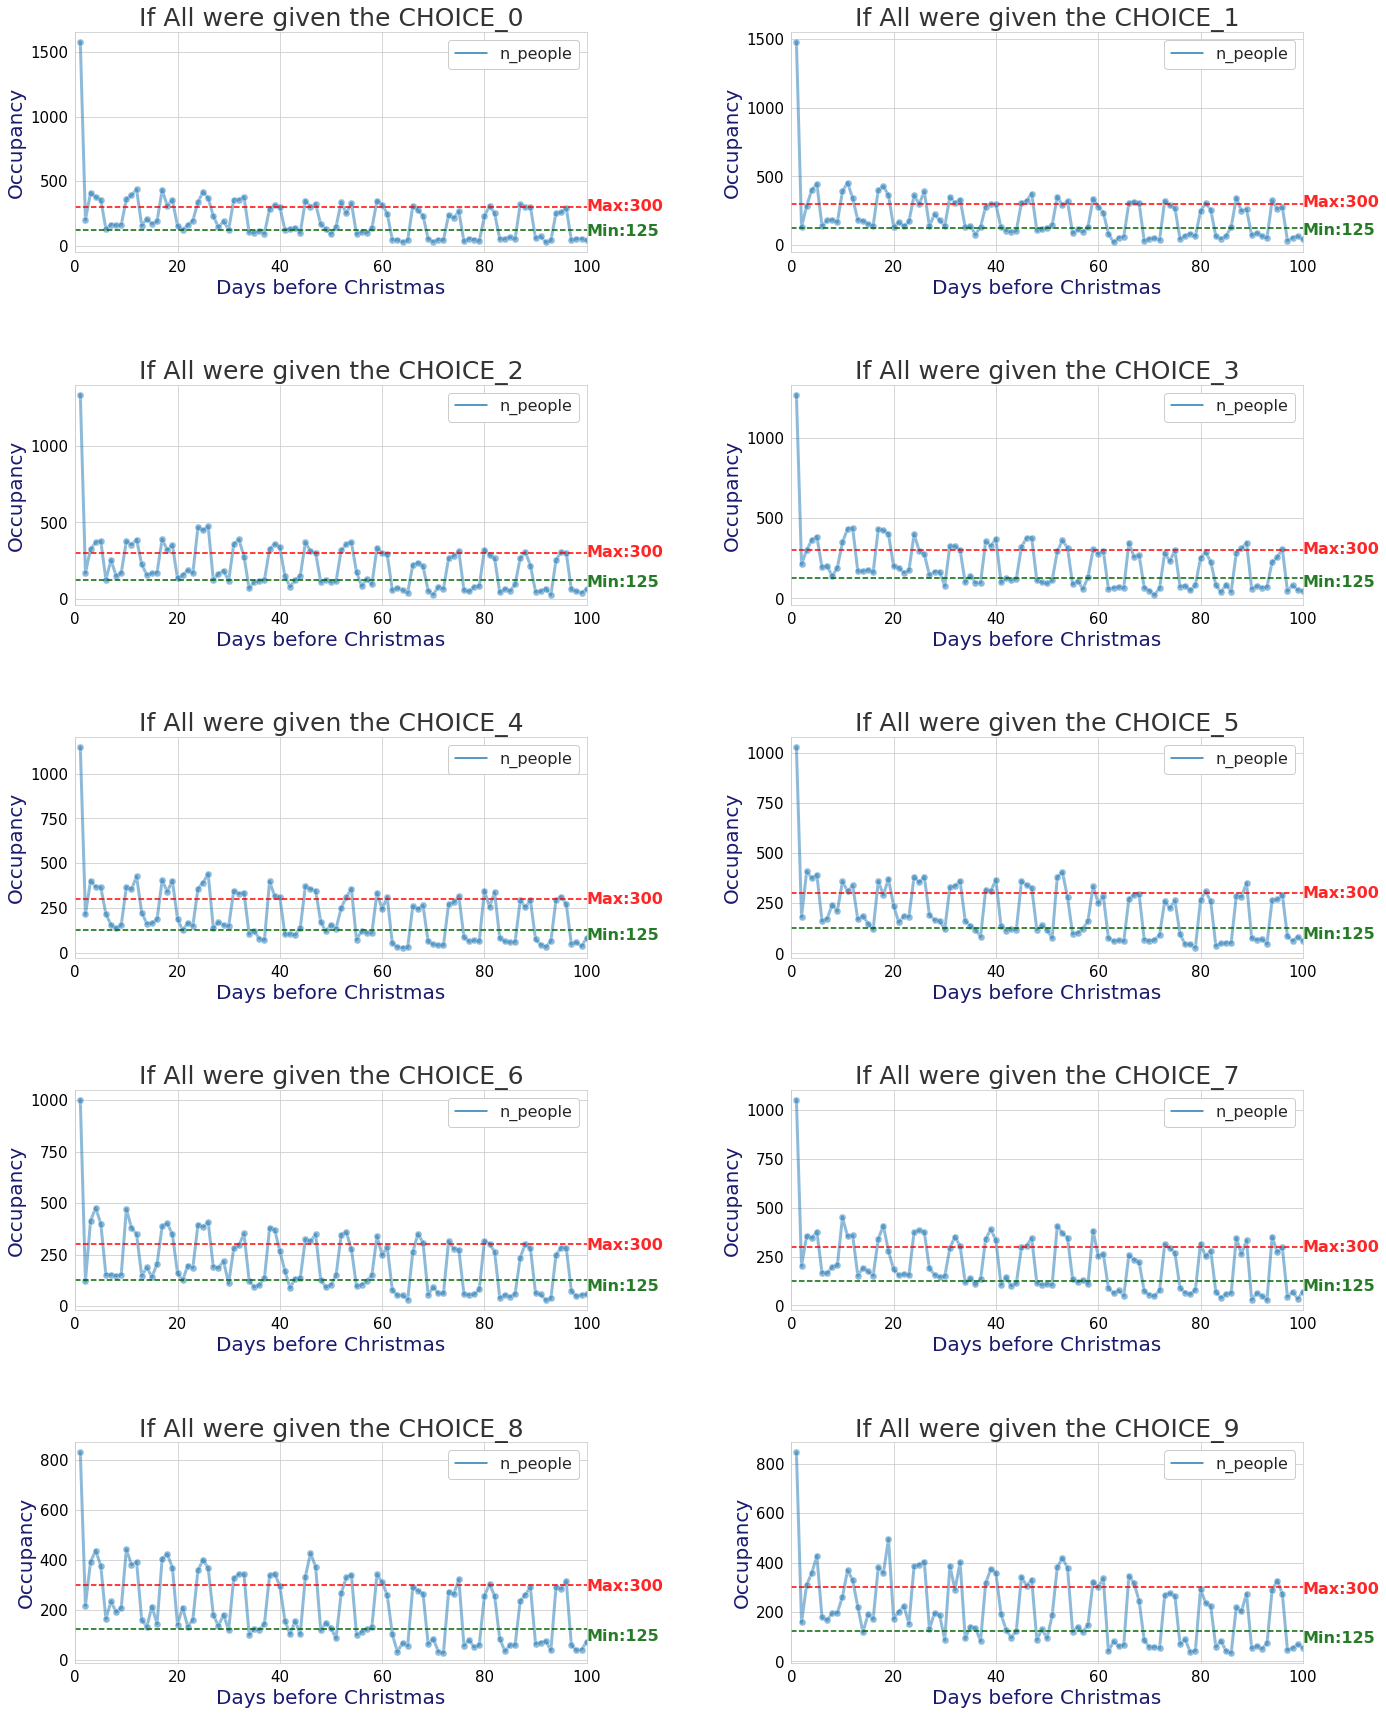

In [8]:
import matplotlib as mpl
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size
# Generate a mask for the upper triangle
sns.set_style("whitegrid")

ax = plt.figure(figsize=(22,30))

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))

for i in range(10):
    choice = pd.pivot_table(data,  index='choice_{}'.format(i), values='n_people',
                             margins=True, aggfunc=np.sum).drop(index='All')
    plt.subplot(5,2,1 + i)
    plt.subplots_adjust(wspace=0.4, hspace=0.6) 
    ax = sns.lineplot(data=choice,marker='o',markersize=7,linewidth=3,alpha=0.5)
    ax.plot([0,125],[125,125],'--',color='darkgreen')
    plt.text(100, 75, 'Min:125', fontsize=16,weight='bold',alpha=0.85,color='darkgreen')
    
    ax.plot([0,300],[300,300],'--',color='red')
    plt.text(100, 275, 'Max:300', fontsize=16,weight='bold',alpha=0.85,color='red')
    plt.title("If All were given the CHOICE_{}".format(i), loc="center",size=25,color='black',alpha=0.8)
    plt.xlabel('Days before Christmas',color='midnightblue',fontsize=20) 
    plt.ylabel('Occupancy',color='midnightblue',fontsize=20)
    plt.xticks(size=15,color='black',rotation='horizontal', wrap=True)
    plt.yticks(size=15,color='black')
    plt.xlim(0,100)
    plt.legend(loc='best', fontsize=16,framealpha=0.99)

In [9]:
# cost_function, etc.

# preference cost
@njit(fastmath=True)
def pcost(prediction):
    daily_occupancy = np.zeros(N_DAYS+1, dtype=np.int64)
    penalty = 0
    for (i, p) in enumerate(prediction):
        n = FAMILY_SIZE[i]
        penalty += PCOSTM[i, p]
        daily_occupancy[p] += n
    return penalty, daily_occupancy


# accounting cost
@njit(fastmath=True)
def acost(daily_occupancy):
    accounting_cost = 0
    n_out_of_range = 0
    daily_occupancy[-1] = daily_occupancy[-2]
    for day in range(N_DAYS):
        n_p1 = daily_occupancy[day + 1]
        n    = daily_occupancy[day]
        diff = abs(n-n_p1)
        n_out_of_range += (n > MAX_OCCUPANCY) or (n < MIN_OCCUPANCY)
        accounting_cost += ACOSTM[diff, n]
    return accounting_cost, n_out_of_range


@njit(fastmath=True)
def acostd(daily_occupancy):
    accounting_cost = np.zeros(N_DAYS, dtype=np.float64)
    n_out_of_range = 0
    daily_occupancy[-1] = daily_occupancy[-2]
    for day in range(N_DAYS):
        n_p1 = daily_occupancy[day + 1]
        n    = daily_occupancy[day]
        diff = abs(n-n_p1)
        n_out_of_range += (n > MAX_OCCUPANCY) or (n < MIN_OCCUPANCY)
        accounting_cost[day] = ACOSTM[diff, n]
    return accounting_cost, n_out_of_range


@njit(fastmath=True)
def pcostd(prediction):
    daily_occupancy = np.zeros(N_DAYS+1, dtype=np.int64)
    penalty = np.empty_like(prediction)
    for (i, p) in enumerate(prediction):
        n = FAMILY_SIZE[i]
        penalty[i] = PCOSTM[i, p]
        daily_occupancy[p] += n
    return penalty, daily_occupancy


@njit(fastmath=True)
def cost_stats(prediction):
    penalty, daily_occupancy = pcostd(prediction)
    accounting_cost, n_out_of_range = acostd(daily_occupancy)
    return penalty, accounting_cost, n_out_of_range, daily_occupancy[:-1]


@njit(fastmath=True)
def cost_function(prediction):
    penalty, daily_occupancy = pcost(prediction)
    accounting_cost, n_out_of_range = acost(daily_occupancy)
    return penalty + accounting_cost + n_out_of_range*100000000

In [10]:
# fixMinOccupancy, fixMaxOccupancy + helpers

@njit(fastmath=True)
def cost_function_(prediction):
    penalty, daily_occupancy = pcost(prediction)
    accounting_cost, n_out_of_range = acost(daily_occupancy)
    return penalty + accounting_cost, n_out_of_range


@njit(fastmath=True)
def findAnotherDay4Fam(prediction, fam, occupancy):
    old_day = prediction[fam]
    best_cost = np.inf
    best_day = fam
    n = FAMILY_SIZE[fam]
    
    daysrange = list(range(0,old_day))+list(range(old_day+1,N_DAYS))
    for day in daysrange:
        prediction[fam] = day
        new_cost, _ = cost_function_(prediction)
        
        if (new_cost<best_cost) and (occupancy[day]+n<=MAX_OCCUPANCY):
            best_cost = new_cost
            best_day = day
            
    prediction[fam] = old_day
    return best_day, best_cost


@njit(fastmath=True)
def bestFamAdd(prediction, day, occupancy):
    best_cost = np.inf
    best_fam = prediction[day]
    for fam in np.where(prediction!=day)[0]:
        old_day = prediction[fam]
        prediction[fam] = day
        new_cost, _ = cost_function_(prediction)
        prediction[fam] = old_day
        n = FAMILY_SIZE[fam]
        if (new_cost<best_cost) and (occupancy[old_day]-n>=MIN_OCCUPANCY):
            best_cost = new_cost
            best_fam = fam   
    return best_fam


@njit(fastmath=True)
def bestFamRemoval(prediction, day, occupancy):
    best_cost = np.inf
    best_day = day
    
    for fam in np.where(prediction==day)[0]:
        new_day, new_cost = findAnotherDay4Fam(prediction, fam, occupancy)
        if new_cost<best_cost:
            best_cost = new_cost
            best_fam = fam
            best_day = new_day
            
    return best_fam, best_day


@njit(fastmath=True)
def fixMaxOccupancy(prediction):
    penalty, accounting_cost, n_out_of_range, occupancy = cost_stats(prediction)

    for day in np.where(occupancy>MAX_OCCUPANCY)[0]:
        while occupancy[day]>MAX_OCCUPANCY:
            fam, new_day = bestFamRemoval(prediction, day, occupancy)
            prediction[fam] = new_day
            penalty, accounting_cost, n_out_of_range, occupancy = cost_stats(prediction)
            
            
@njit(fastmath=True)
def fixMinOccupancy(prediction):
    penalty, accounting_cost, n_out_of_range, occupancy = cost_stats(prediction)

    for day in np.where(occupancy<MIN_OCCUPANCY)[0]:
        while occupancy[day]<MIN_OCCUPANCY:
            fam = bestFamAdd(prediction, day, occupancy)
            prediction[fam] = day
            penalty, accounting_cost, n_out_of_range, occupancy = cost_stats(prediction)

In [11]:
def stochastic_product_search(top_k, fam_size, original, verbose=1000, verbose2=50000,
                              n_iter=500, random_state=42):
    """
    original (np.array): The original day assignments.
    
    At every iterations, randomly sample fam_size families. Then, given their top_k
    choices, compute the Cartesian product of the families' choices, and compute the
    score for each of those top_k^fam_size products.
    """
    
    best = original.copy()
    print('best',best)
    best_score = cost_function(best)
    print('best_score',best_score)
    
    np.random.seed(random_state)
    print('np.random.seed(random_state)',np.random.seed(random_state))

    for i in range(n_iter):
        fam_indices = np.random.choice(range(DESIRED.shape[0]), size=fam_size)
        #print('product(*DESIRED[fam_indices, :top_k].tolist())',product(*DESIRED[fam_indices, :top_k].tolist()))
        changes = np.array(list(product(*DESIRED[fam_indices, :top_k].tolist())))

        for change in changes:
            new = best.copy()
            new[fam_indices] = change

            new_score = cost_function(new)

            if new_score < best_score:
                best_score = new_score
                best = new
                
        if verbose and i % verbose == 0:
            print(f"Iteration #{i}: Best score is {best_score:.2f}      ", end='\r')
            
        if verbose2 and i % verbose2 == 0:
            print(f"Iteration #{i}: Best score is {best_score:.2f}      ")
    
    print(f"Final best score is {best_score:.2f}")
    return best

In [12]:
# original

def stochastic_random_search(original, verbose=100, verbose2=5000,
                              n_iter=100000, random_state=42):
    
    best = original.copy()
    print('best',best)
    best_score = cost_function(best)
    print('best_score',best_score)
    
    np.random.seed(random_state)
    print('np.random.seed(random_state)',np.random.seed(random_state))

    for i in range(n_iter):
        fam_indices = np.random.choice(range(DESIRED.shape[0]), size=3500)
        changes = DESIRED[fam_indices, :5].tolist()
        
        for j in range(3500):
            new = best.copy()
            new[fam_indices[j]] = np.random.choice(changes[j], p=[0.8, 0.15, 0.04, 0.008, 0.002])
        
        new_score = cost_function(new)
        
        if new_score < best_score:
                best_score = new_score
                best = new
                
        if verbose and i % verbose == 0:
            print(f"Iteration #{i}: Best score is {best_score:.2f}      ", end='\r')
            
        if verbose2 and i % verbose2 == 0:
            print(f"Iteration #{i}: Best score is {best_score:.2f}      ")
    
    print(f"Final best score is {best_score:.2f}")
    return best


In [13]:
# original

def fix_accounting_cost(original):
    best = original.copy()
    print('best',best)
    best_score = cost_function(best)
    print('best_score',best_score)
    a = DESIRED[:, :2].tolist()
    
    for i in range(len(best)):
        new = best.copy()
        
        for j in range(len(best)):
            if (a[i][0] == original[i]) & (a[j][1] == original[j]):
                if (a[i][0] == a[j][0]) & (a[i][1] == a[j][1]):
                    new[[i,j]] = new[[j, i]]
                    new_score = cost_function(new)
                    
                    if new_score < best_score:
                        best_score = new_score
                        best = new
    
    print("Final best score is {}".format(best_score))
    return best


## Linear Programing

In [19]:
def solveSantaLP():
    
    S = pywraplp.Solver('SolveAssignmentProblem', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    #S = pywraplp.Solver('SolveAssignmentProblem', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

    x = {}
    for i in range(N_FAMILIES):
        for j in range(N_DAYS):
            x[i, j] = S.BoolVar('x[%i,%i]' % (i, j))
            
            
    daily_occupancy = [S.Sum([x[i, j] * FAMILY_SIZE[i] for i in range(N_FAMILIES)])
                                                       for j in range(N_DAYS)]
    
    family_presence = [S.Sum([x[i, j] for j in range(N_DAYS)])
                                      for i in range(N_FAMILIES)]

    
    
    # Objective
    preference_cost = S.Sum([PCOSTM[i, j] * x[i,j] for i in range(N_FAMILIES)
                                                   for j in range(N_DAYS)])
    
    S.Minimize(preference_cost)

    
    
    # Constraints
    for j in range(N_DAYS-1):
        #S.Add(39*daily_occupancy[j] - 35*daily_occupancy[j+1] <= 1900)   #prediction1
        #S.Add(35*daily_occupancy[j+1] - 31*daily_occupancy[j] <= 1865)   #prediction1
        #S.Add(43*daily_occupancy[j] - 35*daily_occupancy[j+1] <= 2750)  #prediction2
        #S.Add(35*daily_occupancy[j+1] - 27*daily_occupancy[j] <= 2715)  #prediction2
        S.Add(46*daily_occupancy[j] - 35*daily_occupancy[j+1] <= 3300)  #prediction3
        S.Add(35*daily_occupancy[j+1] - 24*daily_occupancy[j] <= 3265)  #prediction3
        
        
    for i in range(N_FAMILIES):
        S.Add(family_presence[i] == 1)

    for j in range(N_DAYS):
        S.Add(daily_occupancy[j] >= MIN_OCCUPANCY)
        S.Add(daily_occupancy[j] <= MAX_OCCUPANCY)

        
    res = S.Solve()
    print("Time = ", S.WallTime(), " milliseconds")
                  
    resdict = {0:'OPTIMAL', 1:'FEASIBLE', 2:'INFEASIBLE', 3:'UNBOUNDED', 
               4:'ABNORMAL', 5:'MODEL_INVALID', 6:'NOT_SOLVED'}
    
    print('Result:', resdict[res])

    l = []
    for i in range(N_FAMILIES):
        for j in range(N_DAYS):
            s = x[i, j].solution_value()
            if s>0:
                l.append((i, j, s))

    df = pd.DataFrame(l, columns=['family_id', 'day', 'n'])

    
    if len(df)!=N_FAMILIES:
        df = df.sort_values(['family_id', 'n']).drop_duplicates('family_id', keep='last') 
     
    return df.day.values

In [15]:
N_DAYS = 100
N_FAMILIES = 5000
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

FAMILY_SIZE = data.n_people.values
DESIRED     = data.values[:, :-1] - 1
PCOSTM = GetPreferenceCostMatrix(data) # Preference cost matrix
ACOSTM = GetAccountingCostMatrix()     # Accounting cost matrix

In [16]:
prediction1 = solveSantaLP()
penalty, accounting_cost, n_out_of_range, occupancy = cost_stats(prediction1)
print('{}, {:.2f}, ({}, {})'.format(penalty.sum(), 
                                    accounting_cost.sum(), 
                                    occupancy.min(), 
                                    occupancy.max()))

Time =  162154  milliseconds
Result: OPTIMAL
71053, 4475.95, (122, 302)


In [18]:
prediction2 = solveSantaLP()
penalty, accounting_cost, n_out_of_range, occupancy = cost_stats(prediction2)
print('{}, {:.2f}, ({}, {})'.format(penalty.sum(), 
                                    accounting_cost.sum(), 
                                    occupancy.min(), 
                                    occupancy.max()))

Time =  164594  milliseconds
Result: OPTIMAL
70746, 4141.10, (122, 299)


In [20]:
prediction3 = solveSantaLP()
penalty, accounting_cost, n_out_of_range, occupancy = cost_stats(prediction3)
print('{}, {:.2f}, ({}, {})'.format(penalty.sum(), 
                                    accounting_cost.sum(), 
                                    occupancy.min(), 
                                    occupancy.max()))

Time =  167226  milliseconds
Result: OPTIMAL
72654, 3135.79, (122, 301)


In [21]:
df0 = data[['choice_0','n_people']]
df0.columns = ['choice_0','n_people']
df1 = pd.DataFrame([prediction1]).transpose()
df1.columns = ['Prediction1']
df2 = pd.DataFrame([prediction2]).transpose()
df2.columns = ['Prediction2']
df3 = pd.DataFrame([prediction3]).transpose()
df3.columns = ['Prediction3']
df = pd.concat([df0,df1,df2, df3], axis=1)
#df.to_csv('Prediction1_3.csv', index=False)

In [22]:
df_t = df.T
df_t.drop(['choice_0', 'n_people'], inplace=True)
prediction = df_t.mode().T
prediction.columns = ['Prediction']
prediction = prediction['Prediction'].values

In [23]:
penalty, accounting_cost, n_out_of_range, occupancy = cost_stats(prediction)
print('{}, {:.2f}, ({}, {})'.format(penalty.sum(), 
                                    accounting_cost.sum(), 
                                    occupancy.min(), 
                                    occupancy.max()))

71140, 3985.05, (122, 299)


In [24]:
fixMinOccupancy(prediction)
fixMaxOccupancy(prediction)
penalty, accounting_cost, n_out_of_range, occupancy = cost_stats(prediction)
print('{}, {:.2f}, ({}, {})'.format(penalty.sum(), 
                                    accounting_cost.sum(), 
                                    occupancy.min(), 
                                    occupancy.max()))

71476, 3853.12, (125, 299)


In [25]:
round2 = stochastic_random_search(original=prediction)

best [51 25 99 ... 31 91 12]
best_score 75329.12356864281
np.random.seed(random_state) None
Iteration #0: Best score is 75329.12      
Iteration #5000: Best score is 73965.88      
Iteration #10000: Best score is 73748.09      
Iteration #15000: Best score is 73666.48      
Iteration #20000: Best score is 73646.14      
Iteration #25000: Best score is 73645.85      
Iteration #30000: Best score is 73614.93      
Iteration #35000: Best score is 73567.90      
Iteration #40000: Best score is 73553.02      
Iteration #45000: Best score is 73486.26      
Iteration #50000: Best score is 73477.56      
Iteration #55000: Best score is 73468.80      
Iteration #60000: Best score is 73464.86      
Iteration #65000: Best score is 73426.50      
Iteration #70000: Best score is 73408.57      
Iteration #75000: Best score is 73386.66      
Iteration #80000: Best score is 73373.99      
Iteration #85000: Best score is 73354.06      
Iteration #90000: Best score is 73334.03      
Iteration #95000: Be

In [26]:
round3 = stochastic_product_search(
        top_k=4,
        fam_size=5, 
        original=round2, 
        n_iter=350000,
        verbose=1,
        verbose2=50000,
        random_state=42
        )

best [51 25 99 ... 31 91 12]
best_score 73279.10661839783
np.random.seed(random_state) None
Iteration #0: Best score is 73279.11      
Iteration #50000: Best score is 72913.27      
Iteration #100000: Best score is 72584.18      
Iteration #150000: Best score is 72444.41      
Iteration #200000: Best score is 72444.41      
Iteration #250000: Best score is 72440.07      
Iteration #300000: Best score is 72396.38      
Final best score is 72353.59e is 72353.59      


In [28]:
final = fix_accounting_cost(round3)

best [51 25 99 ... 31 91 12]
best_score 72353.58784214253
Final best score is 72353.58784214253


In [ ]:
submission = pd.read_csv("./sample_submission1.csv")
submission['assigned_day'] = final+1
#submission.to_csv('submission_72353.59.csv', index=False)